## Poisson Regression Model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display

The following cell generate data from

\begin{align*}
 & \mathrm{P}(y_i=y|x_{1i},x_{2i}) = \frac{e^{-\lambda_i}\lambda_i^y}{y!},\quad y=0,1,2,\dots, \\
 & \lambda_i = \exp(0.5 x_{1i} - 0.5 x_{2i}),\quad i=1,\dots,500.
\end{align*}


In [2]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
lam = np.exp(0.5*x1 - 0.5*x2)
y = st.poisson.rvs(lam)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:24<00:00, 995.60draws/s] 


In [5]:
display(pm.summary(trace))

/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b__0,0.042096,0.047970,0.000419,-0.053448,0.135932,13248.641183,1.000060
b__1,0.475306,0.042850,0.000326,0.392282,0.560524,15647.355839,0.999984
b__2,-0.509982,0.041806,0.000316,-0.593663,-0.430680,15947.847006,1.000187


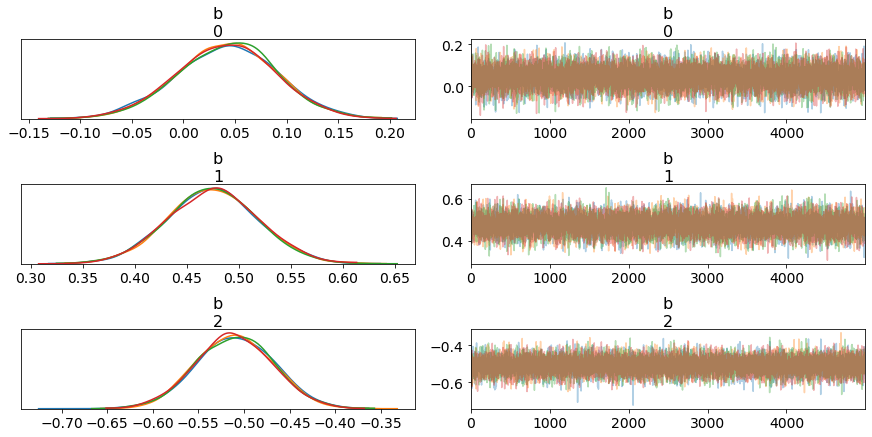

In [6]:
pm.traceplot(trace)
plt.show()

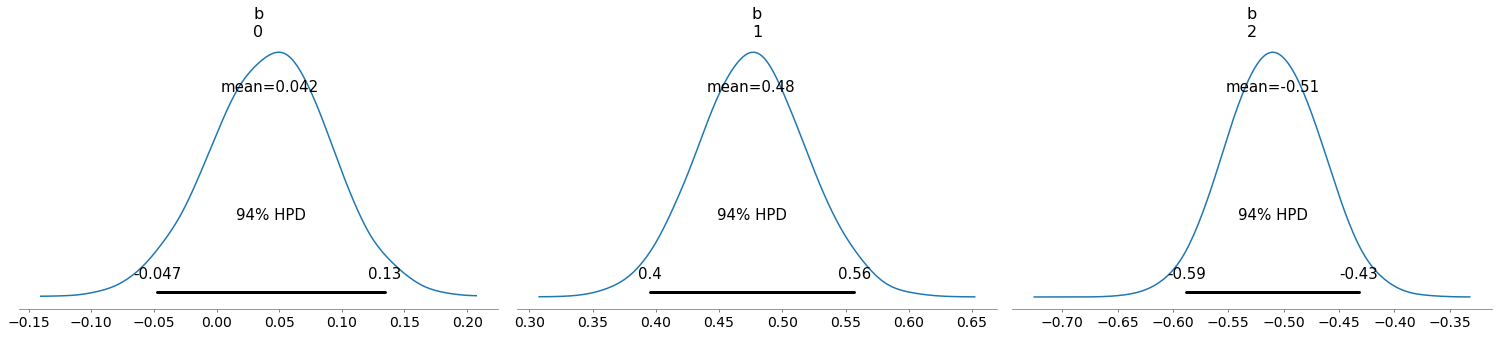

In [7]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean')
plt.show()